<a href="https://colab.research.google.com/github/chinox02/Klasifikasi-Sampah/blob/main/Klasifikasi_Sampah_Yuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
from google.colab import drive
import os

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [64]:
base_dir = '/content/drive/MyDrive/Klasifikasi_Sampah/'

In [65]:
# menentukan direktori
bahan_dir = os.path.join(base_dir, 'bahan')
train_dir = os.path.join(base_dir, 'latih')
validation_dir = os.path.join(base_dir, 'validasi')

In [66]:
# menentukan direktori isi bahan
Kaleng_dir = os.path.join(bahan_dir, 'Kaleng/')
Plastik_dir = os.path.join(bahan_dir, 'Plastik/')

print("jumlah data train tiap kelas")
print('jumlah gambar sampah Kaleng :', len(os.listdir(Kaleng_dir)))
print('jumlah gambar sampah Plastik :', len(os.listdir(Plastik_dir)))

jumlah data train tiap kelas
jumlah gambar sampah Kaleng : 100
jumlah gambar sampah Plastik : 100


In [67]:
# direktori isi latih/training
train_Kaleng = os.path.join(train_dir, 'Kaleng/')
train_Plastik = os.path.join(train_dir, 'Plastik/')

# direktori isi validasi
validation_Kaleng = os.path.join(validation_dir, 'Kaleng/')
validation_Plastik = os.path.join(validation_dir, 'Plastik/')

In [68]:
 import random
 from shutil import copyfile

 def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

#jumlah pembagian data training dan testing
train_ratio = 0.9

#Pembagian Training dan Validasi
# Training
source_00 = Kaleng_dir
train_00 = train_Kaleng
val_00 = validation_Kaleng
train_val_split(source_00, train_00, val_00, train_ratio)

# Validasi
source_01 = Plastik_dir
train_01 = train_Plastik
val_01 = validation_Plastik
train_val_split(source_01, train_01, val_01, train_ratio)

In [69]:
print('jumlah All Kaleng     :', len(os.listdir(Kaleng_dir)))
print('jumlah Train Kaleng   :', len(os.listdir(train_Kaleng)))
print('jumlah Val Kaleng     :', len(os.listdir(validation_Kaleng)))


jumlah All Kaleng     : 100
jumlah Train Kaleng   : 100
jumlah Val Kaleng     : 28


In [70]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [71]:
train_datagen = ImageDataGenerator(
                  rescale = 1./255,
                  rotation_range = 30,
                  horizontal_flip = True,
                  shear_range = 0.3,
                  fill_mode = 'nearest',
                  width_shift_range = 0.2,
                  height_shift_range = 0.2,
                  zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
                 rescale = 1./255,
                 rotation_range = 30,
                 horizontal_flip = True,
                 shear_range = 0.3,
                 fill_mode = 'nearest',
                 width_shift_range = 0.2,
                 height_shift_range = 0.2,
                 zoom_range = 0.1
)

In [72]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 199 images belonging to 2 classes.


In [73]:
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 56 images belonging to 2 classes.


In [74]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.99):
      print('\nAkurasi mencapai 99%')
      self.model.stop_training = True

callbacks = myCallback()

In [75]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dropout(0.3,seed=112),
    tf.keras.layers.Dense(500, activation = 'relu'),
    tf.keras.layers.Dropout(0.5,seed=112),
    tf.keras.layers.Dense(2, activation = 'sigmoid')

])

In [76]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 17, 17, 64)       

In [77]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [78]:
history = model.fit(
    train_generator,
    steps_per_epoch = 6,
    epochs = 25,
    validation_data = val_generator,
    validation_steps = 1,
    verbose = 1,
    callbacks = [callbacks]
)

Epoch 1/25
6/6 [==============================] - 13s 2s/step - loss: 0.9864 - accuracy: 0.4000 - val_loss: 0.6759 - val_accuracy: 0.6000
Epoch 2/25
6/6 [==============================] - 10s 2s/step - loss: 0.6998 - accuracy: 0.4333 - val_loss: 0.6493 - val_accuracy: 0.7000
Epoch 3/25
6/6 [==============================] - 10s 2s/step - loss: 0.6688 - accuracy: 0.6000 - val_loss: 0.6460 - val_accuracy: 0.6000
Epoch 4/25
6/6 [==============================] - 8s 1s/step - loss: 0.6180 - accuracy: 0.7333 - val_loss: 0.4763 - val_accuracy: 1.0000
Epoch 5/25
6/6 [==============================] - 9s 2s/step - loss: 0.3465 - accuracy: 0.9661 - val_loss: 0.0939 - val_accuracy: 1.0000
Epoch 6/25
6/6 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 1.0000
Akurasi mencapai 99%
6/6 [==============================] - 9s 2s/step - loss: 0.0506 - accuracy: 1.0000 - val_loss: 4.8912e-04 - val_accuracy: 1.0000


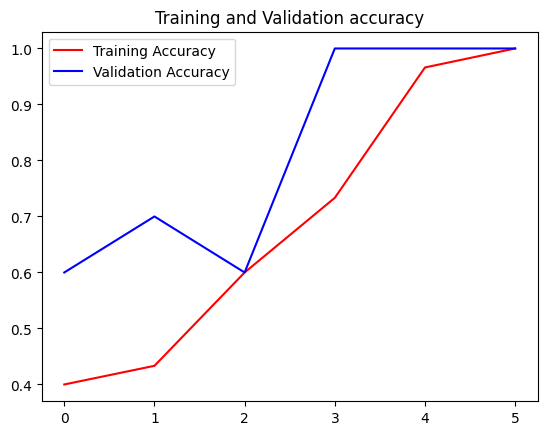

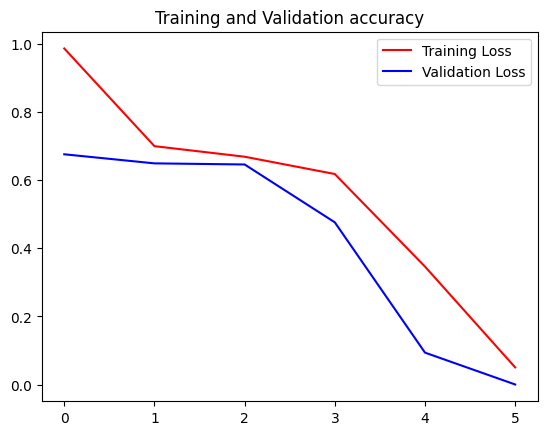

In [85]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

Saving 1713163980735.jpg to 1713163980735.jpg
1/1 [==============================] - 0s 146ms/step
1713163980735.jpg
This image belongs to class Kaleng


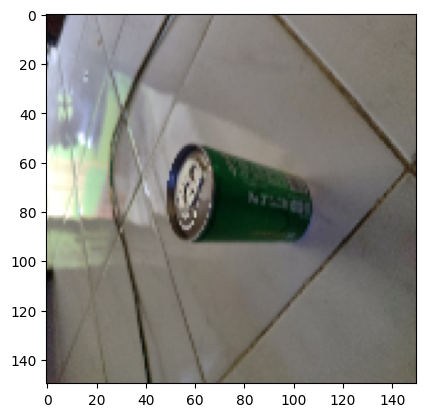

In [86]:
import numpy as np
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size = (150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 100)

  print(fn)

  class_list = os.listdir(train_dir)

  for j in range(42):
    if classes[0][j] == 1. :
      print('This image belongs to class', class_list[j-1])
      break